# MC Path Dependant MC Simulations & Exotic Options Calculation
## Derivatives Exam

_9th December 2023_ <br>
_Fall 2023_ <br>
Derivatives

---
Daniel Gonçalves - 47264


## Imports & Setup

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
sns.set_style('dark',rc={"font.family": "serif", "font.serif": ["Times New Roman"]})

## Define Functions

In [3]:
def generate_sample_path(price, rf, volatility, T, delta_t=1/250, num_simulations=10_000):
    n_periods = int(T/delta_t)
    sims_df = pd.DataFrame(np.random.standard_normal(
        size=(n_periods + 1, num_simulations)))
    sims_df_factor = (
        (sims_df * volatility * np.sqrt(delta_t)) + (rf * delta_t) + 1)
    sims_df_factor.iloc[0] = price
    return sims_df_factor.cumprod()


def plot_simulations(sims_df: pd.DataFrame):
    mean_sim = sims_df.mean(axis=1)
    fig, ax = plt.subplots(figsize=(15, 15*0.618))
    plt.plot(sims_df, alpha=0.4, zorder=0)
    plt.violinplot(sims_df.iloc[-1].values.tolist(),
                   positions=[sims_df.index.max(),], widths=0.05*len(sims_df))
    plt.plot(mean_sim, c="b", linewidth=2)
    plt.text(mean_sim.index.max(), mean_sim.iloc[-1], "Mean\nPrice", color="b")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    plt.ylabel('Stock Price in $')
    plt.xlabel('time t')
    plt.title("Monte Carlo Simulation")
    plt.show()


def plot_probability_histograms(sims_df, time_t):
    plt.hist(sims_df.loc[time_t], density=True)
    plt.title(f'Probability of Simulated Stock Price at time t={time_t}')
    plt.show()

def positive_or_zero(x):
    return x if x > 0 else 0

def call(x,strike_price=0):
    return max(x-strike_price,0)

def put(x,strike_price=0):
    return max(strike_price-x,0)

## Simulation

In [4]:
price = 50
rf = 0.1
T = 10
delta_t = 1/365
volatility = 0.2
num_simulations = 10_000

sims_df = generate_sample_path(price, rf,volatility, T, delta_t,num_simulations)

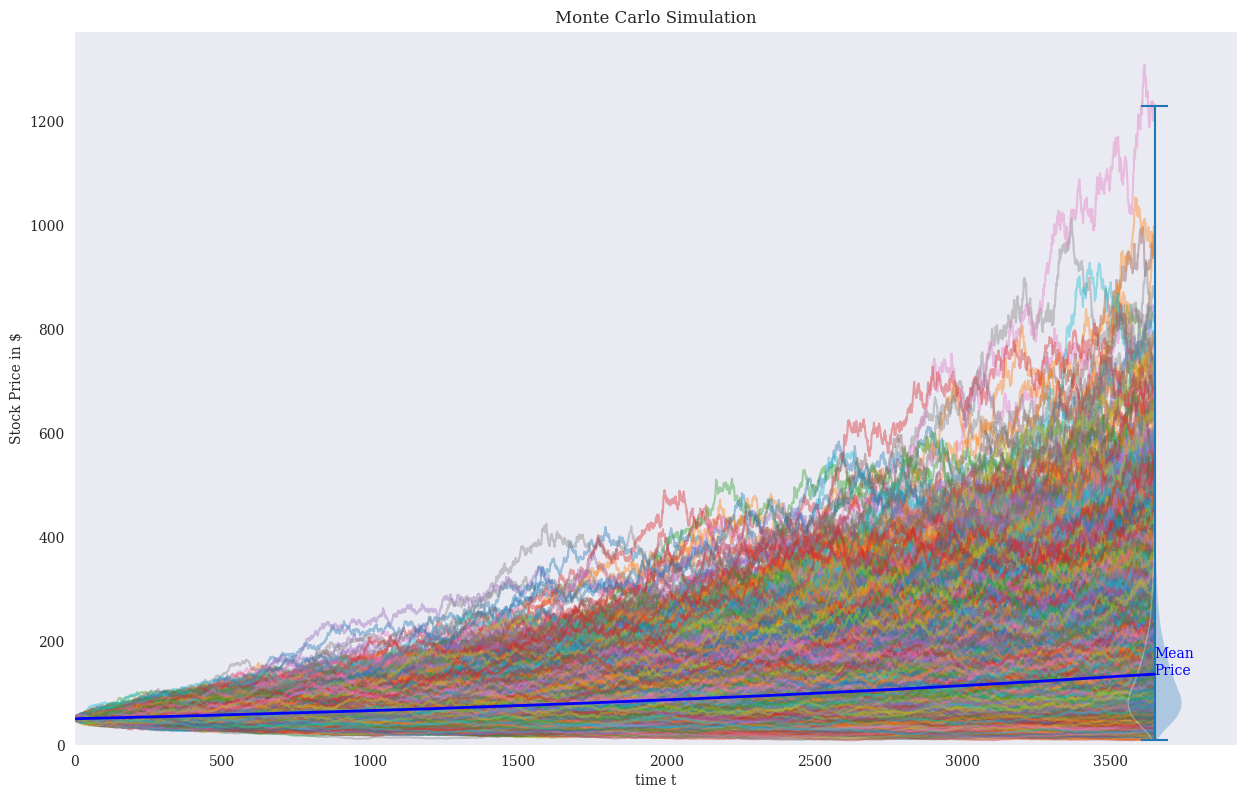

In [4]:
plot_simulations(sims_df)

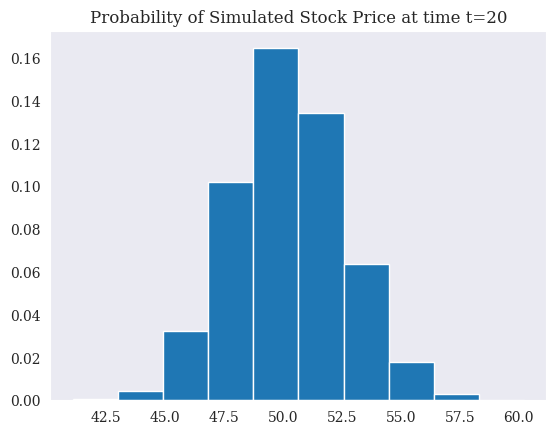

In [5]:
plot_probability_histograms(sims_df, time_t=20)

## Exotic Options Calculation

### Forward Start

In [43]:
t_1 = 2
strike_prices = sims_df.loc[int(t_1 / delta_t)]


forward_start_call = np.exp(-T * rf) * ((sims_df.tail(1).squeeze() - strike_prices).apply(positive_or_zero)).mean()
forward_start_put =  np.exp(-T * rf) * ((strike_prices - sims_df.tail(1).squeeze()).apply(positive_or_zero)).mean()
visuals = pd.DataFrame([forward_start_call, forward_start_put], index=[
                       "Call", "Put"], columns=["Forward Start"])
display(visuals.round(4))

,Forward Start
Call,28.1322
Put,0.6407


### Cash or Nothing
$$
CoN_t = \begin{cases} Q, \text{ if } S_t > X \\ 
0,  \text{ if } S_t \le X
\end{cases}
$$

In [8]:
strike_price = 100
cash_amount = 50
cash_or_nothing_call = np.exp(-T * rf) * sims_df.tail(1).squeeze().apply(
    lambda x: cash_amount if x > strike_price else 0).mean()
cash_or_nothing_put = np.exp(-T * rf) * sims_df.tail(1).squeeze().apply(
    lambda x: cash_amount if x < strike_price else 0).mean()

visuals = pd.DataFrame([cash_or_nothing_call, cash_or_nothing_put], index=[
                       "Call", "Put"], columns=["Cash or Nothing"])
display(visuals.round(4))

,Cash or Nothing
Call,10.3687
Put,8.0253


### Asset or Nothing
$$
AoN_t = \begin{cases} S_t, \text{ if } S_t > X \\ 
0,  \text{ if } S_t \le X
\end{cases}
$$

In [9]:
strike_price = 100
asset_or_nothing_call = np.exp(-T * rf) * sims_df.tail(1).squeeze().apply(lambda x: x if x > strike_price else 0).mean()
asset_or_nothing_put = np.exp(-T * rf) * sims_df.tail(1).squeeze().apply(lambda x: x if x < strike_price else 0).mean()

visuals = pd.DataFrame([asset_or_nothing_call, asset_or_nothing_put], index=[
                       "Call", "Put"], columns=["Asset or Nothing"])
display(visuals.round(4))


,Asset or Nothing
Call,39.2261
Put,10.7109


### Chooser

$$ 
CH_0 = C(X,T) + P(Xe^{-r*(T -t_1)},T_1)

In [49]:
strike_price = 100
t_1 = 2
vanilla_call = np.exp(-T * rf) * sims_df.tail(1).squeeze().apply(call,args=(strike_price,)).mean()

reduced_strike = strike_price * np.exp(-rf * (T-t_1))
reduced_put = np.exp(-t_1 * rf) * sims_df.loc[int(t_1 / delta_t)].squeeze().apply(put,args=(reduced_strike,)).mean()
choser_option = vanilla_call + reduced_put

visuals = pd.DataFrame([vanilla_call, reduced_put,choser_option], index=[
                       "C(X,T)", "P(X red, T1)","Chooser"], columns=["Price"])
display(visuals.round(4))

,Price
"C(X,T)",18.4888
"P(X red, T1)",0.3852
Chooser,18.8740


### Lookback Options
$$
LookBack_{Call} = S_T - S_{min} \\
LookBack_{Put} = S_{max} - S_T
$$

In [11]:
lookback_call = np.exp(-T * rf) * (sims_df.tail(1).squeeze() - sims_df.min()).mean()
lookback_put = np.exp(-T * rf) * (sims_df.max() - sims_df.tail(1).squeeze()).mean()

visuals = pd.DataFrame([lookback_call, lookback_put], index=[
                       "Call", "Put"], columns=["Lookback Options"])
display(visuals.round(4))


,Lookback Options
Call,34.9208
Put,9.3721


### Asian Options

$$
Average Price = \begin{cases} max(S_{avg} - X,0), \text{ for Calls } \\ 
                               max(X - S_{avg},0), \text{ for Put }
\end{cases}
$$
$$
Average Strike = \begin{cases} max(S_t - S_{avg},0), \text{ for Calls } \\ 
                               max(S_{avg} - S_t,0), \text{ for Put }
\end{cases}
$$

In [50]:
strike_price = 100
average_price = sims_df.mean()

average_price_call = np.exp(-T * rf) * ((average_price - strike_price).apply(positive_or_zero).mean())
average_price_put = np.exp(-T * rf) * ((strike_price - average_price).apply(positive_or_zero).mean())

average_strike_call = np.exp(-T * rf) * (sims_df.tail(1).squeeze() - average_price).apply(positive_or_zero).mean()
average_strike_put = np.exp(-T * rf) * (average_price - sims_df.tail(1).squeeze()).apply(positive_or_zero).mean()

visuals = pd.DataFrame([[average_price_call, average_strike_call],[average_price_put,average_strike_put]], index=[
                       "Call", "Put"], columns=["Average Price", "Average Strike"])
display(visuals.round(4))

,Average Price,Average Strike
Call,3.2952,18.8844
Put,8.5337,0.4968


### Barrier Options

In [51]:
# Inputs
barrier = 80
strike_price = 100

# Barriers Diagnostics
barrier_check = np.sign(sims_df - barrier)
barrier_crossing = pd.DataFrame()
barrier_crossing["From Below"] = (
    barrier_check > barrier_check.shift(-1)).any().astype(int)
barrier_crossing["From Above"] = (
    barrier_check < barrier_check.shift(-1)).any().astype(int)

not_barrier_crossing = 1 - barrier_crossing

call_up_in = np.exp(-T * rf) * (barrier_crossing["From Below"] * (sims_df.tail(
    1).squeeze() - strike_price).apply(positive_or_zero)).mean()
call_up_out = np.exp(-T * rf) * (not_barrier_crossing["From Below"] * (sims_df.tail(
    1).squeeze() - strike_price).apply(positive_or_zero)).mean()
call_down_in = np.exp(-T * rf) * (barrier_crossing["From Above"] * (sims_df.tail(
    1).squeeze() - strike_price).apply(positive_or_zero)).mean()
call_down_out = np.exp(-T * rf) * (not_barrier_crossing["From Above"] * (sims_df.tail(
    1).squeeze() - strike_price).apply(positive_or_zero)).mean()

put_up_in = np.exp(-T * rf) * (barrier_crossing["From Below"] * (strike_price - sims_df.tail(
    1).squeeze()).apply(positive_or_zero)).mean()
put_up_out = np.exp(-T * rf) * (not_barrier_crossing["From Below"] * (strike_price - sims_df.tail(
    1).squeeze()).apply(positive_or_zero)).mean()
put_down_in = np.exp(-T * rf) * (barrier_crossing["From Above"] * (strike_price - sims_df.tail(
    1).squeeze()).apply(positive_or_zero)).mean()
put_down_out = np.exp(-T * rf) * (not_barrier_crossing["From Above"] * (strike_price - sims_df.tail(
    1).squeeze()).apply(positive_or_zero)).mean()

visuals = pd.DataFrame([[call_up_in, call_up_out, call_down_in, call_down_out], [
                       put_up_in, put_up_out, put_down_in, put_down_out]], index=["Call","Put"])
visuals.columns = pd.MultiIndex.from_product([["Up","Down"],["In","Out"]])

display(visuals.round(4))

Up             Down        
           In     Out       In     Out
Call  16.6050  1.8838  18.4888  0.0000
Put    2.2585  3.0812   2.2783  3.0614

### Compound Options
#### Call on a Call

In [56]:
strike_price_underlying = 50
strike_price_option = 40
t = 2 # Maturity of the Option

underlying_at_time_t = np.exp(-(T - t) * rf) * (sims_df.tail(1).squeeze() - strike_price_underlying).apply(positive_or_zero)
call_on_call = np.exp(-(t) * rf) * (underlying_at_time_t - strike_price_option).apply(positive_or_zero).mean()
display(call_on_call)

11.912735634208707

#### Put on a Call

In [63]:
strike_price_underlying = 50
strike_price_option = 40
t = 2 # Maturity of the Option

underlying_at_time_t = np.exp(-(T - t) * rf) * (sims_df.tail(1).squeeze() - strike_price_underlying).apply(positive_or_zero)
put_on_call = np.exp(-(t) * rf) * (strike_price_option - underlying_at_time_t).apply(positive_or_zero).mean()
display(round(put_on_call,4))

12.6653

#### Call on Put

In [69]:
strike_price_underlying = 50
strike_price_option = 10
t = 2 # Maturity of the Option

underlying_at_time_t = np.exp(-(T - t) * rf) * (strike_price_underlying - sims_df.tail(1).squeeze()).apply(positive_or_zero)
call_on_put = np.exp(-(t) * rf) * (underlying_at_time_t - strike_price_option).apply(positive_or_zero).mean()
display(round(call_on_put,4))

0.0289

#### Put on a Put

In [68]:
strike_price_underlying = 50
strike_price_option = 10
t = 2 # Maturity of the Option

underlying_at_time_t = np.exp(-(T - t) * rf) * (strike_price_underlying - sims_df.tail(1).squeeze()).apply(positive_or_zero)
put_on_put = np.exp(-(t) * rf) * (strike_price_option - underlying_at_time_t).apply(positive_or_zero).mean()
display(round(put_on_put,4))

7.7626

## Export to Excel

In [16]:
sims_df.to_excel(f"MC_Simulation_Path_P_{price}_vol{volatility}_dt{round(delta_t,2)}.xlsx")